In [2]:
import sys

import meta_dataloader.TCGA

import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2

In [3]:
tasks = meta_dataloader.TCGA.TCGAMeta(min_samples_per_class=10)

In [4]:
print(len(tasks.task_ids))

174


In [5]:
def load_sets(task, valid=False, mlp=True):
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                task._labels, 
                                                                                stratify=task._labels,
                                                                                train_size=50,
                                                                                test_size=100,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                                 )
                                                                                   
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

    if valid:
        X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_test, 
                                                                                y_test, 
                                                                                stratify=y_test,
                                                                                train_size=50,
                                                                                test_size=50,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                               )
        valid_set = TensorDataset( Tensor(X_valid), Tensor(y_valid))
        return train_set, valid_set, test_set
    
    if mlp:
        return train_set, test_set 
    else:
        return X_train, X_test, y_train, y_test

In [6]:
def filter_tasks(tasks_list):
    filtered_tasks_sample = []
    for task in tasks_list: 
        try:
            load_sets(task)
            filtered_tasks_sample.append(task)
        except:
            print("Not enough number of samples in task {}" .format(task.id))
    return filtered_tasks_sample

In [7]:
from sklearn.dummy import DummyClassifier
def Majority(X_train, X_test, y_train, y_test, random_state):
    
    classifier = DummyClassifier(strategy='most_frequent', random_state=random_state)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    accuracy = (predicted == y_test).mean()*100.
    return accuracy

In [8]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, seed, input_size, num_classes, learning_rate, batch_size, epochs):
        super(LogisticRegression, self).__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.linear = torch.nn.Linear(input_size, num_classes)
        
        random.seed(seed)
        torch.manual_seed(seed)
    
    def forward(self, x, params=None):
        return self.linear(x)

    @property
    def criterion(self):
        return torch.nn.CrossEntropyLoss()
    
    @property
    def optimizer(self):
        return torch.optim.LBFGS(self.parameters(), lr=1)



In [9]:
from sklearn.neighbors import KNeighborsClassifier
def K_NN(X_train, X_test, y_train, y_test, random_state, num_neighbors, metric):
    knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = (y_pred == y_test).mean()*100.
    return accuracy

In [10]:
def train(model, dataset, task_id, stop_early=False):
    train_loss = []
    criterion = model.criterion
    if type(model).__name__ == "LogisticRegression":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate, weight_decay= model.weight_decay)
     
    if stop_early:
        print("")
    else:
        train_set = dataset
        valid_set = None
 
    for i in range(model.epochs):
        for batch, labels in torch.utils.data.DataLoader(train_set, batch_size=model.batch_size, shuffle=True):
            labels = torch.autograd.Variable(labels.long())
            
            def closure():
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, labels)
                loss.backward()
                return loss
            
            intermediate = optimizer.step(closure)
            loss = intermediate.item()
            train_loss.append(loss)

    return model, loss

In [11]:
def test(model, test_set):
    # Test the Model
    batch, labels = next(iter(torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)))
    model.eval()
    outputs = model(batch)
    _, predicted = torch.max(outputs.data, 1)

    predicted = predicted.numpy()
    labels = labels.numpy()
    accuracy = (predicted == labels).mean()*100.
    return accuracy

In [12]:
def measure_mean_std(model_dict):
    sorted_x = sorted(model_dict.items(), key=lambda kv: kv[1])
    sorted_dict = collections.OrderedDict(sorted_x)
    mean_std_results = {}
    for task in sorted_dict.keys():
        mean = np.mean(model_dict[task])
        std =  np.std(model_dict[task])
        mean_std_results[task] = {'mean':mean,'std': std}
    return mean_std_results

In [18]:
oct_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'oct_embedded':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        oct_tasks.append(task)
print(len(oct_tasks))

25


In [13]:
valid_tasks = filter_tasks(tasks)
random.seed(9999)
random.shuffle(valid_tasks)
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(len(meta_train_set), len(meta_test_set))

Not enough number of samples in task ('gender', 'UVM')
Not enough number of samples in task ('_EVENT', 'UVM')
Not enough number of samples in task ('histological_type', 'UVM')
Not enough number of samples in task ('gender', 'READ')
Not enough number of samples in task ('_EVENT', 'READ')
Not enough number of samples in task ('lymphatic_invasion', 'READ')
Not enough number of samples in task ('venous_invasion', 'READ')
Not enough number of samples in task ('colon_polyps_present', 'READ')
Not enough number of samples in task ('gender', 'ACC')
Not enough number of samples in task ('_EVENT', 'ACC')
Not enough number of samples in task ('oct_embedded', 'ACC')
Not enough number of samples in task ('clinical_M', 'ACC')
Not enough number of samples in task ('necrosis', 'ACC')
Not enough number of samples in task ('weiss_venous_invasion', 'ACC')
Not enough number of samples in task ('atypical_mitotic_figures', 'ACC')
Not enough number of samples in task ('hypertension', 'UCEC')
Not enough number

In [19]:
avg_maj_acc, avg_lr_acc, avg_knn_acc = {}, {}, {}
weight_decay = 0.0
batch_size = 32
epochs=250
num_neighbour = 4
metric = 'euclidean'
tasks_ids = []
for task in valid_tasks:
    #task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    for seed in range(10):
            X_train, X_test, y_train, y_test = load_sets(task, False, False)
            tasks_ids.append(task.id)
            #-----Majority-----
            mj_acc = Majority(X_train, X_test, y_train, y_test, seed)
            print("{} Majority Accuracy is: {}" .format(task.id, mj_acc))
            if task.id in avg_maj_acc.keys():
                avg_maj_acc[task.id].append(mj_acc)
            else:
                avg_maj_acc[task.id] = [mj_acc]
                
            #-----------KNN-------------
            knn_acc = K_NN(X_train, X_test, y_train, y_test, seed, num_neighbour, metric)
            print("{} KNN Accuracy is: {}" .format(task.id, knn_acc))
            if task.id in avg_knn_acc.keys():
                avg_knn_acc[task.id].append(knn_acc)
            else:
                avg_knn_acc[task.id] = [knn_acc]

            #-----Logistic Regression-----
            lr = 1.
            LR_model = LogisticRegression(seed, input_size, num_classes,lr, batch_size, epochs)
            train_set, test_set =  load_sets(task, False)
            trained_model, train_loss = train(LR_model, train_set, task.id, False)
            lr_result = test(trained_model, test_set)
            print("{} LR Accuracy is: {}" .format(task.id, lr_result))
            if task.id in avg_lr_acc.keys():
                avg_lr_acc[task.id].append(lr_result)
            else:
                avg_lr_acc[task.id] = [lr_result]
    print('\n')

('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') KNN Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') KNN Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 64.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') KNN Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 70.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') KNN Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 79.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') KNN Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 79.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') KNN Accuracy is: 71.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 72.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('

('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 52.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') KNN Accuracy is: 48.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 47.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') KNN Accuracy is: 48.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 49.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') KNN Accuracy is: 48.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 53.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') KNN Accuracy is: 48.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 50.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') KNN Accuracy is: 48.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 46.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANC

('_PANCAN_mirna_BRCA', 'BRCA') LR Accuracy is: 33.0
('_PANCAN_mirna_BRCA', 'BRCA') Majority Accuracy is: 32.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 33.0
('_PANCAN_mirna_BRCA', 'BRCA') LR Accuracy is: 39.0


('oct_embedded', 'HNSC') Majority Accuracy is: 51.0
('oct_embedded', 'HNSC') KNN Accuracy is: 56.00000000000001
('oct_embedded', 'HNSC') LR Accuracy is: 50.0
('oct_embedded', 'HNSC') Majority Accuracy is: 51.0
('oct_embedded', 'HNSC') KNN Accuracy is: 56.00000000000001
('oct_embedded', 'HNSC') LR Accuracy is: 52.0
('oct_embedded', 'HNSC') Majority Accuracy is: 51.0
('oct_embedded', 'HNSC') KNN Accuracy is: 56.00000000000001
('oct_embedded', 'HNSC') LR Accuracy is: 52.0
('oct_embedded', 'HNSC') Majority Accuracy is: 51.0
('oct_embedded', 'HNSC') KNN Accuracy is: 56.00000000000001
('oct_embedded', 'HNSC') LR Accuracy is: 52.0
('oct_embedded', 'HNSC') Majority Accuracy is: 51.0
('oct_embedded', 'HNSC') KNN Accuracy is: 56.00000000000001
('oct_embedded', 'HNSC') LR Accuracy is

('animal_insect_allergy_history', 'GBMLGG') LR Accuracy is: 90.0
('animal_insect_allergy_history', 'GBMLGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'GBMLGG') KNN Accuracy is: 95.0
('animal_insect_allergy_history', 'GBMLGG') LR Accuracy is: 95.0


('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') KNN Accuracy is: 46.0
('gender', 'LAML') LR Accuracy is: 90.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') KNN Accuracy is: 46.0
('gender', 'LAML') LR Accuracy is: 70.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') KNN Accuracy is: 46.0
('gender', 'LAML') LR Accuracy is: 84.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') KNN Accuracy is: 46.0
('gender', 'LAML') LR Accuracy is: 80.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') KNN Accuracy is: 46.0
('gender', 'LAML') LR Accuracy is: 81.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') KNN Accuracy is: 46.0
('gender'

('gender', 'COADREAD') LR Accuracy is: 70.0
('gender', 'COADREAD') Majority Accuracy is: 54.0
('gender', 'COADREAD') KNN Accuracy is: 60.0
('gender', 'COADREAD') LR Accuracy is: 96.0
('gender', 'COADREAD') Majority Accuracy is: 54.0
('gender', 'COADREAD') KNN Accuracy is: 60.0
('gender', 'COADREAD') LR Accuracy is: 75.0


('alcohol_history_documented', 'HNSC') Majority Accuracy is: 67.0
('alcohol_history_documented', 'HNSC') KNN Accuracy is: 48.0
('alcohol_history_documented', 'HNSC') LR Accuracy is: 65.0
('alcohol_history_documented', 'HNSC') Majority Accuracy is: 67.0
('alcohol_history_documented', 'HNSC') KNN Accuracy is: 48.0
('alcohol_history_documented', 'HNSC') LR Accuracy is: 66.0
('alcohol_history_documented', 'HNSC') Majority Accuracy is: 67.0
('alcohol_history_documented', 'HNSC') KNN Accuracy is: 48.0
('alcohol_history_documented', 'HNSC') LR Accuracy is: 68.0
('alcohol_history_documented', 'HNSC') Majority Accuracy is: 67.0
('alcohol_history_documented', 'HNSC') KNN Accura

('family_history_of_stomach_cancer', 'STAD') KNN Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') LR Accuracy is: 90.0
('family_history_of_stomach_cancer', 'STAD') Majority Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') KNN Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') LR Accuracy is: 86.0
('family_history_of_stomach_cancer', 'STAD') Majority Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') KNN Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') LR Accuracy is: 93.0
('family_history_of_stomach_cancer', 'STAD') Majority Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') KNN Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') LR Accuracy is: 91.0
('family_history_of_stomach_cancer', 'STAD') Majority Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') KNN Accuracy is: 95.0
('family_history_of_stomach_cancer', 'STAD') LR Accuracy is: 94.0
('family_history_of_stomach_cancer', 'STAD') Ma

('_PANCAN_mirna_LUSC', 'LUSC') LR Accuracy is: 56.00000000000001


('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') KNN Accuracy is: 77.0
('oct_embedded', 'PRAD') LR Accuracy is: 79.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') KNN Accuracy is: 77.0
('oct_embedded', 'PRAD') LR Accuracy is: 80.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') KNN Accuracy is: 77.0
('oct_embedded', 'PRAD') LR Accuracy is: 85.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') KNN Accuracy is: 77.0
('oct_embedded', 'PRAD') LR Accuracy is: 78.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') KNN Accuracy is: 77.0
('oct_embedded', 'PRAD') LR Accuracy is: 74.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') KNN Accuracy is: 77.0
('oct_embedded', 'PRAD') LR Accuracy is: 80.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embed

('_EVENT', 'OV') LR Accuracy is: 53.0
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 49.0
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 51.0
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 56.99999999999999
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 55.00000000000001
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 55.00000000000001
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 56.99999999999999
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KNN Accuracy is: 47.0
('_EVENT', 'OV') LR Accuracy is: 52.0
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') KN

('_EVENT', 'BLCA') LR Accuracy is: 60.0
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') KNN Accuracy is: 47.0
('_EVENT', 'BLCA') LR Accuracy is: 61.0
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') KNN Accuracy is: 47.0
('_EVENT', 'BLCA') LR Accuracy is: 61.0
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') KNN Accuracy is: 47.0
('_EVENT', 'BLCA') LR Accuracy is: 53.0
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') KNN Accuracy is: 47.0
('_EVENT', 'BLCA') LR Accuracy is: 53.0
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') KNN Accuracy is: 47.0
('_EVENT', 'BLCA') LR Accuracy is: 56.00000000000001
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') KNN Accuracy is: 47.0
('_EVENT', 'BLCA') LR Accuracy is: 63.0


('GeneExp_Subtype', 'GBM') Majority Accuracy is: 33.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 65.0
('

('_EVENT', 'COADREAD') LR Accuracy is: 70.0
('_EVENT', 'COADREAD') Majority Accuracy is: 76.0
('_EVENT', 'COADREAD') KNN Accuracy is: 74.0
('_EVENT', 'COADREAD') LR Accuracy is: 71.0


('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') KNN Accuracy is: 46.0
('_EVENT', 'PAAD') LR Accuracy is: 62.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') KNN Accuracy is: 46.0
('_EVENT', 'PAAD') LR Accuracy is: 66.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') KNN Accuracy is: 46.0
('_EVENT', 'PAAD') LR Accuracy is: 48.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') KNN Accuracy is: 46.0
('_EVENT', 'PAAD') LR Accuracy is: 61.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') KNN Accuracy is: 46.0
('_EVENT', 'PAAD') LR Accuracy is: 53.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') KNN Accuracy is: 46.0
('_EVENT', 'PAAD') LR Accuracy is: 64.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVEN

('_EVENT', 'SKCM') LR Accuracy is: 63.0
('_EVENT', 'SKCM') Majority Accuracy is: 52.0
('_EVENT', 'SKCM') KNN Accuracy is: 56.00000000000001
('_EVENT', 'SKCM') LR Accuracy is: 63.0
('_EVENT', 'SKCM') Majority Accuracy is: 52.0
('_EVENT', 'SKCM') KNN Accuracy is: 56.00000000000001
('_EVENT', 'SKCM') LR Accuracy is: 62.0
('_EVENT', 'SKCM') Majority Accuracy is: 52.0
('_EVENT', 'SKCM') KNN Accuracy is: 56.00000000000001
('_EVENT', 'SKCM') LR Accuracy is: 63.0


('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') KNN Accuracy is: 74.0
('_EVENT', 'COAD') LR Accuracy is: 66.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') KNN Accuracy is: 74.0
('_EVENT', 'COAD') LR Accuracy is: 76.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') KNN Accuracy is: 74.0
('_EVENT', 'COAD') LR Accuracy is: 72.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') KNN Accuracy is: 74.0
('_EVENT', 'COAD') LR Accuracy is: 74.0
('_EVENT', 'COAD') Majority Ac

('anatomic_neoplasm_subdivision', 'PAAD') LR Accuracy is: 76.0
('anatomic_neoplasm_subdivision', 'PAAD') Majority Accuracy is: 77.0
('anatomic_neoplasm_subdivision', 'PAAD') KNN Accuracy is: 73.0
('anatomic_neoplasm_subdivision', 'PAAD') LR Accuracy is: 73.0
('anatomic_neoplasm_subdivision', 'PAAD') Majority Accuracy is: 77.0
('anatomic_neoplasm_subdivision', 'PAAD') KNN Accuracy is: 73.0
('anatomic_neoplasm_subdivision', 'PAAD') LR Accuracy is: 74.0
('anatomic_neoplasm_subdivision', 'PAAD') Majority Accuracy is: 77.0
('anatomic_neoplasm_subdivision', 'PAAD') KNN Accuracy is: 73.0
('anatomic_neoplasm_subdivision', 'PAAD') LR Accuracy is: 69.0
('anatomic_neoplasm_subdivision', 'PAAD') Majority Accuracy is: 77.0
('anatomic_neoplasm_subdivision', 'PAAD') KNN Accuracy is: 73.0
('anatomic_neoplasm_subdivision', 'PAAD') LR Accuracy is: 70.0
('anatomic_neoplasm_subdivision', 'PAAD') Majority Accuracy is: 77.0
('anatomic_neoplasm_subdivision', 'PAAD') KNN Accuracy is: 73.0
('anatomic_neoplasm_

('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 56.99999999999999
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 60.0
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 57.99999999999999
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 56.00000000000001
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 56.99999999999999
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 56.00000000000001
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy is: 63.0
('_EVENT', 'LIHC') LR Accuracy is: 55.00000000000001
('_EVENT', 'LIHC') Majority Accuracy is: 61.0
('_EVENT', 'LIHC') KNN Accuracy i

('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 67.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 66.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 68.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 65.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 71.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 70.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN Accuracy is: 73.0
('clinical_M', 'KIRP') LR Accuracy is: 62.0
('clinical_M', 'KIRP') Majority Accuracy is: 75.0
('clinical_M', 'KIRP') KNN 

('family_history_of_primary_brain_tumor', 'GBMLGG') LR Accuracy is: 95.0
('family_history_of_primary_brain_tumor', 'GBMLGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') LR Accuracy is: 95.0
('family_history_of_primary_brain_tumor', 'GBMLGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') LR Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') LR Accuracy is: 95.0
('family_history_of_primary_brain_tumor', 'GBMLGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'GBMLGG') LR Accuracy is: 96.0


('gender', 'HNSC') Ma

('_EVENT', 'LAML') LR Accuracy is: 50.0


('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') KNN 

('_EVENT', 'LUSC') LR Accuracy is: 56.99999999999999
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') KNN Accuracy is: 54.0
('_EVENT', 'LUSC') LR Accuracy is: 56.99999999999999
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') KNN Accuracy is: 54.0
('_EVENT', 'LUSC') LR Accuracy is: 57.99999999999999
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') KNN Accuracy is: 54.0
('_EVENT', 'LUSC') LR Accuracy is: 57.99999999999999


('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('hist

('Node_nature2012', 'BRCA') LR Accuracy is: 34.0
('Node_nature2012', 'BRCA') Majority Accuracy is: 49.0
('Node_nature2012', 'BRCA') KNN Accuracy is: 49.0
('Node_nature2012', 'BRCA') LR Accuracy is: 30.0


('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') KNN Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 80.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') KNN Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 79.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') KNN Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 84.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') KNN Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 80.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') KNN Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 76.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') KNN Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 79.0
('_EVENT', 'BRCA') Majority Accur

('family_history_of_primary_brain_tumor', 'LGG') LR Accuracy is: 95.0
('family_history_of_primary_brain_tumor', 'LGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') LR Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') LR Accuracy is: 95.0
('family_history_of_primary_brain_tumor', 'LGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') LR Accuracy is: 95.0
('family_history_of_primary_brain_tumor', 'LGG') Majority Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') KNN Accuracy is: 96.0
('family_history_of_primary_brain_tumor', 'LGG') LR Accuracy is: 88.0
('family_history_of_primary_brain_tumor', 'LGG') Majority Accu

('gender', 'LUNG') LR Accuracy is: 91.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 82.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 92.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 84.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 90.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 89.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 86.0
('gender', 'LUNG') Majority Accuracy is: 60.0
('gender', 'LUNG') KNN Accuracy is: 76.0
('gender', 'LUNG') LR Accuracy is: 90.0


('oct_embedded', 'LIHC') Majority Accuracy is: 65.0
('oct_embedded', 

('family_history_of_cancer', 'LGG') KNN Accuracy is: 61.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 62.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') KNN Accuracy is: 61.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 49.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') KNN Accuracy is: 61.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 53.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') KNN Accuracy is: 61.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 50.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') KNN Accuracy is: 61.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 53.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') KNN Accuracy is: 61.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 

('_EVENT', 'GBMLGG') LR Accuracy is: 74.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 74.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 73.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 73.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 75.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 75.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 74.0
('_EVENT', 'GBMLGG') Majority Accuracy is: 62.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 71.0
('_EVENT', 'GBMLGG') LR Accuracy is: 74.0
('_EVENT', 'GBMLGG') Majori

('mental_status_changes', 'GBMLGG') KNN Accuracy is: 74.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 66.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') KNN Accuracy is: 74.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 65.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') KNN Accuracy is: 74.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 67.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') KNN Accuracy is: 74.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 66.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') KNN Accuracy is: 74.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 64.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') KNN Accuracy is: 74.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 

('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 56.00000000000001
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lymphovascular_invasion_present', 'BLCA') KNN Accuracy is: 48.0
('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 53.0
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lymphovascular_invasion_present', 'BLCA') KNN Accuracy is: 48.0
('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 50.0


('histological_type', 'UCEC') Majority Accuracy is: 62.0
('histological_type', 'UCEC') KNN Accuracy is: 75.0
('histological_type', 'UCEC') LR Accuracy is: 72.0
('histological_type', 'UCEC') Majority Accuracy is: 62.0
('histological_type', 'UCEC') KNN Accuracy is: 75.0
('histological_type', 'UCEC') LR Accuracy is: 66.0
('histological_type', 'UCEC') Majority Accuracy is: 62.0
('histological_type', 'UCEC') KNN Accuracy is: 75.0
('histological_type', 'UCEC') LR Accuracy is: 62.0
('histolog

In [38]:
avg_maj_acc, avg_lr_acc, avg_knn_acc = {}, {}, {}
weight_decay = 0.0
batch_size = 32
epochs=250
num_neighbour = 4
metric = 'euclidean'
tasks_ids = []
for task in meta_test_set:
    #task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    for seed in range(10):
            X_train, X_test, y_train, y_test = load_sets(task, False, False)
            tasks_ids.append(task.id)
            #-----Majority-----
            mj_acc = Majority(X_train, X_test, y_train, y_test, seed)
            print("{} Majority Accuracy is: {}" .format(task.id, mj_acc))
            if task.id in avg_maj_acc.keys():
                avg_maj_acc[task.id].append(mj_acc)
            else:
                avg_maj_acc[task.id] = [mj_acc]
                
            #-----------KNN-------------
            knn_acc = K_NN(X_train, X_test, y_train, y_test, seed, num_neighbour, metric)
            print("{} KNN Accuracy is: {}" .format(task.id, knn_acc))
            if task.id in avg_knn_acc.keys():
                avg_knn_acc[task.id].append(knn_acc)
            else:
                avg_knn_acc[task.id] = [knn_acc]

            #-----Logistic Regression-----
            lr = 1.
            LR_model = LogisticRegression(seed, input_size, num_classes,lr, batch_size, epochs)
            train_set, test_set =  load_sets(task, False)
            trained_model, train_loss = train(LR_model, train_set, task.id, False)
            lr_result = test(trained_model, test_set)
            print("{} LR Accuracy is: {}" .format(task.id, lr_result))
            if task.id in avg_lr_acc.keys():
                avg_lr_acc[task.id].append(lr_result)
            else:
                avg_lr_acc[task.id] = [lr_result]
    print('\n')

('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Accuracy is: 75.0
('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Accuracy is: 77.0
('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Accuracy is: 81.0
('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Accuracy is: 78.0
('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Accuracy is: 76.0
('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Accuracy is: 77.0
('oct_embedded', 'SARC') Majority Accuracy is: 85.0
('oct_embedded', 'SARC') KNN Accuracy is: 70.0
('oct_embedded', 'SARC') LR Acc

('histological_type', 'LGG') KNN Accuracy is: 46.0
('histological_type', 'LGG') LR Accuracy is: 56.00000000000001
('histological_type', 'LGG') Majority Accuracy is: 38.0
('histological_type', 'LGG') KNN Accuracy is: 46.0
('histological_type', 'LGG') LR Accuracy is: 56.99999999999999


('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') KNN Accuracy is: 68.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 65.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') KNN Accuracy is: 68.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 60.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') KNN Accuracy is: 68.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 61.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', '

('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC') KNN Accuracy is: 56.99999999999999
('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC') LR Accuracy is: 50.0


('gender', 'COAD') Majority Accuracy is: 54.0
('gender', 'COAD') KNN Accuracy is: 63.0
('gender', 'COAD') LR Accuracy is: 96.0
('gender', 'COAD') Majority Accuracy is: 54.0
('gender', 'COAD') KNN Accuracy is: 63.0
('gender', 'COAD') LR Accuracy is: 94.0
('gender', 'COAD') Majority Accuracy is: 54.0
('gender', 'COAD') KNN Accuracy is: 63.0
('gender', 'COAD') LR Accuracy is: 94.0
('gender', 'COAD') Majority Accuracy is: 54.0
('gender', 'COAD') KNN Accuracy is: 63.0
('gender', 'COAD') LR Accuracy is: 97.0
('gender', 'COAD') Majority Accuracy is: 54.0
('gender', 'COAD') KNN Accuracy is: 63.0
('gender', 'COAD') LR Accuracy is: 88.0
('gender', 'COAD') Majority Accuracy is: 54.0
('gender', 'COAD') KNN Accuracy is: 63.0
('gender', 'COAD') LR Accuracy is: 97.0
('gender', 'COAD') Majority Accuracy is: 54.0
('gender', '

('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') LR Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') Majority Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') LR Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') Majority Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') LR Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') Majority Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') LR Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') Majority Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') LR Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') Majority Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') LR Accuracy is: 98.0


('anatomic_neoplasm_subdivi

('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 67.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') KNN Accuracy is: 54.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 67.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') KNN Accuracy is: 54.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 60.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') KNN Accuracy is: 54.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 56.99999999999999
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') KNN Accuracy is: 54.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 66.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') KNN Accuracy is: 54.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 71.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is:

In [54]:
#for tuning k (num_neighbours)
avg_knn_acc_k5 = {}
weight_decay = 0.0
batch_size = 32
epochs=250
num_neighbour = 5
metric = 'euclidean'
tasks_ids = []
for task in valid_tasks:
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    for seed in range(10):
            X_train, X_test, y_train, y_test = load_sets(task, False, False)
            tasks_ids.append(task.id)
            #-----------KNN-------------
            knn_acc = K_NN(X_train, X_test, y_train, y_test, seed, num_neighbour, metric)
            print("{} KNN Accuracy is: {}" .format(task.id, knn_acc))
            if task.id in avg_knn_acc_k5.keys():
                avg_knn_acc_k5[task.id].append(knn_acc)
            else:
                avg_knn_acc_k5[task.id] = [knn_acc]

('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('histological_type', 'PRAD') KNN Accuracy is: 97.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('oct_embedded', 'PRAD') KNN Accuracy is: 78.0
('biochemi

('oct_embedded', 'UCEC') KNN Accuracy is: 50.0
('oct_embedded', 'UCEC') KNN Accuracy is: 50.0
('oct_embedded', 'UCEC') KNN Accuracy is: 50.0
('oct_embedded', 'UCEC') KNN Accuracy is: 50.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('gender', 'BLCA') KNN Accuracy is: 72.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy is: 51.0
('_EVENT', 'BLCA') KNN Accuracy i

('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('_EVENT', 'GBM') KNN Accuracy is: 71.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('GeneExp_Subtype', 'GBM') KNN Accuracy is: 70.0
('_EVENT', 'OV') KNN Accuracy is: 55.00000000000001
('_EVENT', 'OV') KNN Accuracy is: 55.00000000000001
('_EVE

('_EVENT', 'KIRP') KNN Accuracy is: 84.0
('_EVENT', 'KIRP') KNN Accuracy is: 84.0
('_EVENT', 'KIRP') KNN Accuracy is: 84.0
('_EVENT', 'KIRP') KNN Accuracy is: 84.0
('_EVENT', 'KIRP') KNN Accuracy is: 84.0
('_EVENT', 'KIRP') KNN Accuracy is: 84.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('oct_embedded', 'KIRP') KNN Accuracy is: 61.0
('clinical_stage', 'KIRP') KNN Accuracy is: 67.0
('clinical_stage', 'KIRP') KNN Accuracy is: 67.0
('clinical_stage', 'KIRP') KNN Accuracy is: 67.0
('clinical_stage', 'KIRP') KNN Accuracy is: 67.0
('clinical_stage', 'KIRP') KNN Accuracy is: 67.0
('clinical_stage', 'KIRP') KNN Accuracy

('_EVENT', 'LGG') KNN Accuracy is: 77.0
('_EVENT', 'LGG') KNN Accuracy is: 77.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('histological_type', 'LGG') KNN Accuracy is: 50.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 46.0
('oct_embedded', 'LGG') KNN Accuracy is: 4

('tumor_tissue_site', 'COADREAD') KNN Accuracy is: 74.0
('tumor_tissue_site', 'COADREAD') KNN Accuracy is: 74.0
('tumor_tissue_site', 'COADREAD') KNN Accuracy is: 74.0
('tumor_tissue_site', 'COADREAD') KNN Accuracy is: 74.0
('tumor_tissue_site', 'COADREAD') KNN Accuracy is: 74.0
('tumor_tissue_site', 'COADREAD') KNN Accuracy is: 74.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('_EVENT', 'COADREAD') KNN Accuracy is: 69.0
('lymphatic_invasion', 'COADREAD') KNN Accuracy is: 63.0
('lymphatic_invasion', 'COADREAD') KNN Accuracy is: 63.0
('lymphatic_invasion', 'COADREAD') KNN Accuracy is: 63.0
('lymphatic_invasion', 'COADREAD') KNN Accu

('gender', 'GBMLGG') KNN Accuracy is: 64.0
('gender', 'GBMLGG') KNN Accuracy is: 64.0
('gender', 'GBMLGG') KNN Accuracy is: 64.0
('gender', 'GBMLGG') KNN Accuracy is: 64.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') KNN Accuracy is: 95.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 75.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 75.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 75.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 75.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 75.0
('_EVENT', 'GBMLGG') KNN Accuracy is: 75.0
('_EVENT', 'GBMLGG') KNN Accur

('Node_nature2012', 'BRCA') KNN Accuracy is: 46.0
('Node_nature2012', 'BRCA') KNN Accuracy is: 46.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('Metastasis_nature2012', 'BRCA') KNN Accuracy is: 98.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 37.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 37.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 37.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 37.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 37.0
('_PANCAN_mirna_BRCA', 'BRCA') KNN Accuracy is: 37.0
('_PANCAN_mirna_BRCA',

In [26]:
print(len(avg_maj_acc))

25


In [27]:
print(len(avg_lr_acc))

25


In [28]:
print(len(avg_knn_acc))

25


In [39]:
Maj_dict = measure_mean_std(avg_maj_acc)

In [40]:
print(Maj_dict)

{('_PANCAN_mirna_LUAD', 'LUAD'): {'mean': 31.0, 'std': 0.0}, ('_PANCAN_mirna_LAML', 'LAML'): {'mean': 35.0, 'std': 0.0}, ('histological_type', 'LGG'): {'mean': 38.0, 'std': 0.0}, ('_PANCAN_DNAMethyl_HNSC', 'HNSC'): {'mean': 41.0, 'std': 0.0}, ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC'): {'mean': 52.0, 'std': 0.0}, ('gender', 'COAD'): {'mean': 54.0, 'std': 0.0}, ('lymphovascular_invasion_present', 'BLCA'): {'mean': 55.000000000000014, 'std': 7.105427357601002e-15}, ('oct_embedded', 'THCA'): {'mean': 57.999999999999986, 'std': 7.105427357601002e-15}, ('gender', 'LUNG'): {'mean': 60.0, 'std': 0.0}, ('family_history_of_cancer', 'LGG'): {'mean': 62.0, 'std': 0.0}, ('_EVENT', 'GBMLGG'): {'mean': 62.0, 'std': 0.0}, ('histological_type', 'UCEC'): {'mean': 62.0, 'std': 0.0}, ('lymphovascular_invasion_present', 'HNSC'): {'mean': 64.0, 'std': 0.0}, ('oct_embedded', 'LIHC'): {'mean': 65.0, 'std': 0.0}, ('oct_embedded', 'UCEC'): {'mean': 65.0, 'std': 0.0}, ('gender', 'LIHC'): {'mea

In [41]:
import os
path = 'results/'
result_dataframe = pd.DataFrame.from_dict(Maj_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'Majority_result_10seeds.csv'))

In [42]:
LR_dict= measure_mean_std(avg_lr_acc)

In [43]:
path = 'results/'
result_dataframe = pd.DataFrame.from_dict(LR_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'LogisticRegression_result_10seeds.csv'))

In [44]:
print(LR_dict)

{('_PANCAN_mirna_LUAD', 'LUAD'): {'mean': 37.3, 'std': 2.4919871588754225}, ('family_history_of_cancer', 'LGG'): {'mean': 50.7, 'std': 4.859012245302537}, ('lymphovascular_invasion_present', 'BLCA'): {'mean': 53.8, 'std': 2.9597297173897497}, ('histological_type', 'LGG'): {'mean': 54.7, 'std': 2.002498439450078}, ('anatomic_neoplasm_subdivision', 'OV'): {'mean': 59.6, 'std': 5.782732917920385}, ('oct_embedded', 'UCEC'): {'mean': 57.1, 'std': 2.6248809496813372}, ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC'): {'mean': 51.6, 'std': 3.0397368307141326}, ('oct_embedded', 'LIHC'): {'mean': 61.2, 'std': 2.135415650406263}, ('_PANCAN_DNAMethyl_HNSC', 'HNSC'): {'mean': 64.8, 'std': 4.686149805543994}, ('lymphovascular_invasion_present', 'HNSC'): {'mean': 60.0, 'std': 3.3763886032268258}, ('mental_status_changes', 'GBMLGG'): {'mean': 65.3, 'std': 1.6155494421403511}, ('oct_embedded', 'THCA'): {'mean': 64.9, 'std': 3.2999999999999994}, ('colon_polyps_present', 'COADREAD'): {'mean'

In [46]:
KNN_dict= measure_mean_std(avg_knn_acc)
path = 'results/'
result_dataframe = pd.DataFrame.from_dict(KNN_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'KNN_result_10seeds.csv'))
print(KNN_dict)

{('histological_type', 'LGG'): {'mean': 46.0, 'std': 0.0}, ('_PANCAN_mirna_LUAD', 'LUAD'): {'mean': 47.0, 'std': 0.0}, ('lymphovascular_invasion_present', 'BLCA'): {'mean': 48.0, 'std': 0.0}, ('oct_embedded', 'THCA'): {'mean': 52.0, 'std': 0.0}, ('oct_embedded', 'UCEC'): {'mean': 53.0, 'std': 0.0}, ('_PANCAN_DNAMethyl_HNSC', 'HNSC'): {'mean': 54.0, 'std': 0.0}, ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC'): {'mean': 56.999999999999986, 'std': 7.105427357601002e-15}, ('family_history_of_cancer', 'LGG'): {'mean': 61.0, 'std': 0.0}, ('gender', 'COAD'): {'mean': 63.0, 'std': 0.0}, ('oct_embedded', 'SKCM'): {'mean': 67.0, 'std': 0.0}, ('oct_embedded', 'LIHC'): {'mean': 67.0, 'std': 0.0}, ('lymphovascular_invasion_present', 'HNSC'): {'mean': 68.0, 'std': 0.0}, ('_PANCAN_mirna_LAML', 'LAML'): {'mean': 69.0, 'std': 0.0}, ('oct_embedded', 'SARC'): {'mean': 70.0, 'std': 0.0}, ('_EVENT', 'GBMLGG'): {'mean': 71.0, 'std': 0.0}, ('gender', 'LIHC'): {'mean': 72.0, 'std': 0.0}, ('colon_

In [16]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, seed, input_size, num_classes, num_layers, channels, learning_rate, batch_size, epochs, patience, weight_decay):
        super(MultiLayerPerceptron, self).__init__()
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.weight_decay = weight_decay
        self.num_layers = num_layers
        self.channels = channels
        self.output_size = num_classes
        random.seed(seed)
        torch.manual_seed(seed)
        
        nodes = []
        nodes += channels
        architecture = OrderedDict()
        for i in range(self.num_layers):
            architecture['fc' + str(i)] = nn.Linear(input_size, nodes[i])
            architecture['relu' + str(i)] = torch.nn.ReLU()
            input_size = nodes[i]

        self.features = nn.Sequential(architecture)

        self.classifier = nn.Linear(input_size, num_classes)
    
    @property
    def criterion(self):
        criterion = F.cross_entropy
        return criterion
    
    @property
    def optimizer(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

    def forward(self, x):
        x = x.view(-1, self.input_size)
        features = self.features(x)
        logits = self.classifier(features)
        return logits

In [17]:
#After hyperparameter search (in another notebook)
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0

In [31]:
avg_mlp_acc = {}

for task in meta_test_set:
    #task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    try:
        train_set, test_set = load_sets(task, valid = False)
        for seed in range(0,10):
            MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
            trained_model, train_loss = train(MLP_model, train_set, task.id, False)
            mlp_result = test(trained_model, test_set)
            print("\n {} MLP Accuracy is: {}" .format(task.id, mlp_result))
            if task.id in avg_mlp_acc.keys():
                avg_mlp_acc[task.id].append(mlp_result)
            else:
                avg_mlp_acc[task.id] = [mlp_result]
    except:
        print("Not enough number of samples")


 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 81.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SARC') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 79.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 80.0

 ('oct_embedded', 'SKCM') MLP Accuracy is: 77.0

 ('gender', 'LIHC')


 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('Metastasis_nature2012', 'BRCA') MLP Accuracy is: 98.0

 ('anatomic_neoplasm_subdivision', 'OV') MLP Accuracy is: 72.0

 ('anatomic_neoplasm_subdivision', 'OV') MLP Accuracy is: 72.0

 ('anatomic_neoplasm_subdivision', 'OV') MLP Accuracy is: 72.0

 ('anatomic_neoplasm_subdivision', 'OV') MLP Accuracy is: 72.0

 ('anatomic_neoplasm_subdivision', 'OV') MLP Accuracy is: 72.0

 ('anatomic_neoplasm_subdivision', 'OV') MLP Accuracy is: 72.0

 ('anatomic_neoplasm_subdivision', 

In [37]:
import os
MLP_dict = measure_mean_std(avg_mlp_acc)
print(MLP_dict)

path = 'results/'
result_dataframe = pd.DataFrame.from_dict(MLP_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'MLP_result_10seeds.csv'))

{('_PANCAN_mirna_LUAD', 'LUAD'): {'mean': 39.7, 'std': 1.0999999999999999}, ('lymphovascular_invasion_present', 'BLCA'): {'mean': 53.1, 'std': 0.9433981132056604}, ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC'): {'mean': 54.6, 'std': 0.4898979485566391}, ('histological_type', 'LGG'): {'mean': 55.6, 'std': 0.7999999999999989}, ('family_history_of_cancer', 'LGG'): {'mean': 55.2, 'std': 1.1661903789690622}, ('oct_embedded', 'UCEC'): {'mean': 57.1, 'std': 0.5385164807134475}, ('oct_embedded', 'LIHC'): {'mean': 64.6, 'std': 0.66332495807108}, ('lymphovascular_invasion_present', 'HNSC'): {'mean': 64.3, 'std': 1.1874342087037917}, ('oct_embedded', 'THCA'): {'mean': 66.8, 'std': 0.6}, ('mental_status_changes', 'GBMLGG'): {'mean': 67.3, 'std': 0.6403124237432849}, ('colon_polyps_present', 'COADREAD'): {'mean': 68.8, 'std': 0.6}, ('_PANCAN_mirna_LAML', 'LAML'): {'mean': 71.3, 'std': 1.3453624047073711}, ('histological_type', 'UCEC'): {'mean': 71.7, 'std': 0.6403124237432849}, ('ana

In [35]:
sorted_x = sorted(MLP_dict.items(), key=lambda kv: kv[1])
sorted_mlp_dict = collections.OrderedDict(sorted_x)
print(sorted_mlp_dict)

TypeError: '<' not supported between instances of 'dict' and 'dict'

In [22]:
task_u = meta_dataloader.TCGA.TCGATask(('oct_embedded', 'STAD'))
input_size = task_u._samples.shape[1]
num_classes = len(collections.Counter(task_u._labels))
train_set, test_set = load_sets(task_u, valid = False)
for seed in range(0,10):
    MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
    trained_model, train_loss = train(MLP_model, train_set, task_u.id, False)
    mlp_result = test(trained_model, test_set)
    print("\n {} MLP Accuracy is: {}" .format(task_u.id, mlp_result))     



 ('oct_embedded', 'STAD') MLP Accuracy is: 61.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 60.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 60.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 60.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 59.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 57.99999999999999

 ('oct_embedded', 'STAD') MLP Accuracy is: 59.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 59.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 60.0

 ('oct_embedded', 'STAD') MLP Accuracy is: 60.0


In [17]:
avg_mlp_acc = {}

for task in valid_tasks:
    #task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    try:
        train_set, test_set = load_sets(task, valid = False)
        for seed in range(0,10):
            MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
            trained_model, train_loss = train(MLP_model, train_set, task.id, False)
            mlp_result = test(trained_model, test_set)
            print("\n {} MLP Accuracy is: {}" .format(task.id, mlp_result))
            if task.id in avg_mlp_acc.keys():
                avg_mlp_acc[task.id].append(mlp_result)
            else:
                avg_mlp_acc[task.id] = [mlp_result]
    except:
        print("Not enough number of samples")


 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('histological_type', 'PRAD') MLP Accuracy is: 97.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 76.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 76.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 76.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 76.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 76.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 76.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 77.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 77.0

 ('oct_embedded', 'PRAD') MLP Accuracy is: 77.0

 ('oct_embedded', 


 ('histological_type', 'UCEC') MLP Accuracy is: 72.0

 ('histological_type', 'UCEC') MLP Accuracy is: 71.0

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.00000000000001

 ('oct_embedded', 'UCEC') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 57.99999999999999

 ('oct_embedded', 'UCEC') MLP Accuracy is: 57.99999999999999

 ('gender', 'BLCA') MLP Accuracy is: 78.0

 ('gender', 'BLCA') MLP Accuracy is: 77.0

 ('gender', 'BLCA') MLP Accuracy is: 78.0

 ('gender', 'BLCA') MLP Accuracy is: 78.0

 ('gender', 'BLCA') MLP Accuracy is: 78.0

 ('gender', 'BLCA') MLP Accuracy is: 77.0

 ('gender', '


 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 53.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 53.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 52.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 54.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 52.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 54.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 52.0

 ('birth_control_pill_history_usage_category', 'CESC') MLP Accuracy is: 53.0

 ('gender', 'GBM') MLP Accuracy is: 64.0

 ('gender', 'GBM') MLP Accuracy is: 64.0

 ('gender', 'GBM') MLP Accuracy is: 65.0

 ('gender', 'GBM') MLP Accuracy is: 64.0

 ('gender', 'GBM') MLP Accuracy is: 65.0

 ('gender', 'GBM') MLP Accuracy is: 64.0

 ('gender', 'GBM') MLP Accuracy is: 63.0

 ('gender', 'GBM') MLP Accuracy is: 65.0

 ('gender', 'GBM') MLP Accuracy is: 65.


 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 74.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 74.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 74.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 74.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 49.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 50.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 49.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 50.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 49.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 50.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 49.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 49.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 50.0

 ('alcohol_history_documented', 'PAAD') MLP Accuracy is: 50.0

 ('gender', 'KIRP') MLP Accuracy is: 81.0

 ('gender', 'KIRP') MLP Accuracy is: 81.0

 ('gender', 'KIRP')


 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 55.00000000000001

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 57.99999999999999

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 54.0

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 60.0

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 59.0

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 56.99999999999999

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 57.99999999999999

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 61.0

 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 57.99999999999999

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 64.0

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 61.0

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 66.0

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 60.0

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 66.0

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 61.0

 ('_PANCAN_mirna_LUSC', 'LUSC') MLP Accuracy is: 63.0

 ('_PANCAN_mirna_L


 ('_EVENT', 'LIHC') MLP Accuracy is: 64.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 64.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 65.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 64.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 64.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 64.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 63.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 64.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 65.0

 ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC') MLP Accuracy is: 54.0

 ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC') MLP Accuracy is: 54.0

 ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC') MLP Accuracy is: 55


 ('alcohol_history_documented', 'ESCA') MLP Accuracy is: 68.0

 ('alcohol_history_documented', 'ESCA') MLP Accuracy is: 67.0

 ('gender', 'LAML') MLP Accuracy is: 52.0

 ('gender', 'LAML') MLP Accuracy is: 52.0

 ('gender', 'LAML') MLP Accuracy is: 50.0

 ('gender', 'LAML') MLP Accuracy is: 50.0

 ('gender', 'LAML') MLP Accuracy is: 50.0

 ('gender', 'LAML') MLP Accuracy is: 52.0

 ('gender', 'LAML') MLP Accuracy is: 50.0

 ('gender', 'LAML') MLP Accuracy is: 51.0

 ('gender', 'LAML') MLP Accuracy is: 52.0

 ('gender', 'LAML') MLP Accuracy is: 50.0

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 56.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999999

 ('_EVENT', 'LAML') MLP Accuracy is: 57.99999999999


 ('gender', 'BRCA') MLP Accuracy is: 99.0

 ('gender', 'BRCA') MLP Accuracy is: 99.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('_EVENT', 'BRCA') MLP Accuracy is: 85.0

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'BRCA') MLP Accuracy is: 57.99999999999999

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.99999999999999

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.00000000000001

 ('oct_embedded', 'BRCA') MLP Accuracy is: 56.999

In [152]:
for name, param in MLP_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

features.fc0.weight tensor([[ 0.0030, -0.0095,  0.0002,  ...,  0.0006,  0.0044,  0.0019],
        [ 0.0010, -0.0108, -0.0016,  ...,  0.0027,  0.0011,  0.0044],
        [-0.0066, -0.0017, -0.0058,  ...,  0.0047, -0.0065, -0.0055],
        ...,
        [-0.0063,  0.0008,  0.0043,  ..., -0.0053,  0.0014, -0.0070],
        [-0.0022,  0.0029, -0.0035,  ...,  0.0014, -0.0047, -0.0049],
        [ 0.0011, -0.0012,  0.0060,  ...,  0.0069,  0.0017, -0.0029]])
features.fc0.bias tensor([-2.7376e-03, -1.5950e-04,  2.0330e-05, -6.4027e-04,  6.9196e-03,
         4.6968e-03,  2.7326e-03, -5.8876e-03, -3.4663e-03,  7.1009e-05,
         6.7886e-03, -7.1999e-04,  4.9171e-03, -5.2966e-03, -4.6967e-03,
         6.9845e-05, -4.9631e-03, -2.7643e-04, -5.8544e-04, -2.6221e-03,
        -5.1977e-03, -4.9420e-03,  6.0976e-03, -4.0843e-03,  2.4464e-03,
         3.0079e-03, -3.0391e-06,  3.4180e-04,  5.8997e-03,  2.8183e-03,
        -1.3503e-03, -5.6021e-03,  2.2059e-03, -2.8572e-03, -1.6787e-03,
         5.9832e-

In [133]:
print(len(avg_mlp_acc))

23


In [153]:
MLP_dict = measure_mean_std(avg_mlp_acc)
print(MLP_dict)

{('_EVENT', 'BLCA'): {'mean': 56.4, 'std': 0.7999999999999939}, ('_EVENT', 'BRCA'): {'mean': 85.0, 'std': 0.0}, ('_EVENT', 'CESC'): {'mean': 63.0, 'std': 0.0}, ('_EVENT', 'COAD'): {'mean': 74.4, 'std': 0.4898979485566356}, ('_EVENT', 'COADREAD'): {'mean': 66.7, 'std': 0.7810249675906654}, ('_EVENT', 'ESCA'): {'mean': 56.2, 'std': 0.7483314773547822}, ('_EVENT', 'GBM'): {'mean': 72.1, 'std': 0.30000000000000004}, ('_EVENT', 'GBMLGG'): {'mean': 74.0, 'std': 0.4472135954999579}, ('_EVENT', 'HNSC'): {'mean': 60.0, 'std': 2.144761058952723}, ('_EVENT', 'KIRP'): {'mean': 83.2, 'std': 0.4}, ('_EVENT', 'LAML'): {'mean': 57.999999999999986, 'std': 0.44721359549995954}, ('_EVENT', 'LGG'): {'mean': 74.1, 'std': 0.8306623862918076}, ('_EVENT', 'LIHC'): {'mean': 63.9, 'std': 0.7000000000000001}, ('_EVENT', 'LUAD'): {'mean': 58.5, 'std': 0.6708203932499401}, ('_EVENT', 'LUNG'): {'mean': 62.1, 'std': 0.8306623862918074}, ('_EVENT', 'LUSC'): {'mean': 55.0, 'std': 0.6324555320336781}, ('_EVENT', 'OV'):

In [146]:
import os
path = 'results/'
result_dataframe = pd.DataFrame.from_dict(MLP_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'MLP_result_10seeds.csv'))

In [12]:
def all_visualization(Maj_means, Knn_means, LR_means, Mlp_means, Maj_std, Knn_stds, LR_std, Mlp_std, tasks):
    
    path = "results"
    x = np.arange(len(tasks))
    new_x = [2*i for i in x]
    fig, ax = plt.subplots(figsize=(100, 20), dpi=150)
    width = 0.3
    colors = ['#332288', '#AA4499', '#44AA99','g']
    ax.bar([p - 2*width for p in new_x],
            Maj_means,
            width,
            alpha=0.7,
            color='#332288',
            label='Majority')
    ax.bar([p - width for p in new_x],
            Mlp_means,
            width,
            alpha=0.7,
            color='#44AA99',
            label='KNN')
    ax.bar(new_x,
            LR_means,
            width,
            alpha=0.7,
            color='#AA4499',
            label='LR')
    ax.bar([p + width for p in new_x],
            Mlp_means,
            width,
            alpha=0.7,
            color='#44AA99',
            label='MLP')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performances over tasks')
    ax.set_xticks([p  for p in new_x])
    ax.set_xticklabels(tasks, rotation=45, ha="right")
    fig.tight_layout()

    plt.legend(['Majority', 'KNN', 'LR', 'MLP'], loc='upper left')
    plt.grid()
    
    # Error bars
    x_e, y_e, e = [], [], []
    for i in new_x:
        x_e.append([i-2*width, i-width, i, i+width])

    for i, task in enumerate(tasks):
        y_e.append([Maj_means[i], Knn_means[i], LR_means[i], Mlp_means[i]])

    for i, task in enumerate(tasks):
        e.append([Maj_std[i], Knn_std[i], LR_std[i], Mlp_std[i]])

    flatten_x = [item for sublist in x_e for item in sublist]
    flatten_y = [item for sublist in y_e for item in sublist]
    flatten_e = [item for sublist in e for item in sublist]


    plt.xlim(min(new_x) - 3 * width, max(new_x) + width * 3)
    plt.ylim(0, 100)

    plt.errorbar(flatten_x, flatten_y, flatten_e, linestyle='None', marker='o', color='r', alpha=0.7)
    plt.rcParams.update({'font.size':35})
    plt.savefig(path + '/results_all_model_new.png')
    plt.show()

In [125]:
#Filtered task Ids
tasks_ids = []
for task in filtered_tasks:
    #task = meta_dataloader.TCGA.TCGATask(taskid)
    try:
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                    task._labels, 
                                                                                    stratify=task._labels,
                                                                                    train_size=50,
                                                                                    test_size=100,
                                                                                    shuffle=True,
                                                                                    random_state=0
                                                                                     )
        tasks_ids.append(task.id)
    except:
        print("Not enough number of samples.")

Not enough number of samples.
Not enough number of samples.
Not enough number of samples.
Not enough number of samples.
Not enough number of samples.
Not enough number of samples.
Not enough number of samples.


In [23]:
print(df['Unnamed: 0']+'|'+df['Unnamed: 1'])

0                               _PANCAN_mirna_LUAD|LUAD
1                  lymphovascular_invasion_present|BLCA
2     adjacent_hepatic_tissue_inflammation_extent_ty...
3                                 histological_type|LGG
4                          family_history_of_cancer|LGG
5                                     oct_embedded|UCEC
6                                     oct_embedded|LIHC
7                  lymphovascular_invasion_present|HNSC
8                                     oct_embedded|THCA
9                          mental_status_changes|GBMLGG
10                        colon_polyps_present|COADREAD
11                              _PANCAN_mirna_LAML|LAML
12                               histological_type|UCEC
13                     anatomic_neoplasm_subdivision|OV
14                          _PANCAN_DNAMethyl_HNSC|HNSC
15                                        _EVENT|GBMLGG
16                                          gender|LUNG
17                                          gend

In [14]:
import matplotlib.pyplot as plt
maj_acc, maj_stds = [], []
Maj_res= []
csv_file = 'results/Majority_result_10seeds.csv'
df = pd.read_csv(csv_file)
for i in df['mean']:
    maj_acc.append(i)

for i in df['std']:
    maj_stds.append(i)
Maj_res.append(maj_acc)
Maj_res.append(maj_stds)

knn_acc, knn_stds = [], []
KNN_res= []
csv_file = 'results/KNN_result_10seeds.csv'
df = pd.read_csv(csv_file)
for i in df['mean']:
    knn_acc.append(i)
    
for i in df['std']:
    knn_stds.append(i)

KNN_res.append(knn_acc)
KNN_res.append(knn_stds)


lr_acc, lr_stds = [], []
LR_res= []
csv_file = 'results/LogisticRegression_result_10seeds.csv'
df = pd.read_csv(csv_file)
for i in df['mean']:
    lr_acc.append(i)
    
for i in df['std']:
    lr_stds.append(i)

LR_res.append(lr_acc)
LR_res.append(lr_stds)

mlp_acc, mlp_stds = [], []
MLP_res= []
csv_file = 'results/MLP_result_10seeds.csv'
df = pd.read_csv(csv_file)
for i in df['mean']:
    mlp_acc.append(i)
    
for i in df['std']:
    mlp_stds.append(i)

MLP_res.append(mlp_acc)
MLP_res.append(mlp_stds)

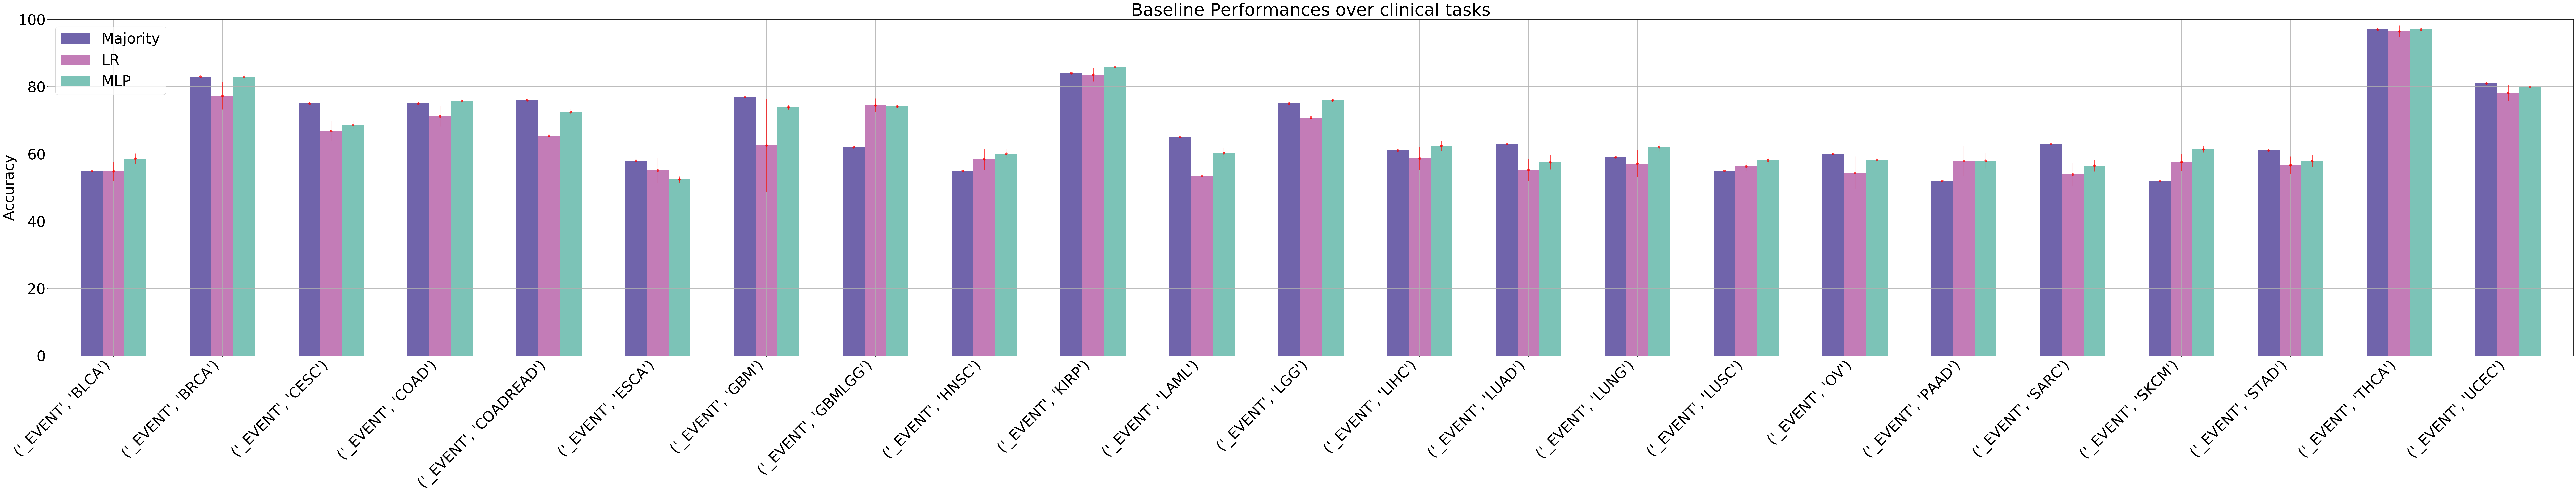

In [35]:
all_visualization(maj_means, lr_means, mlp_means, maj_stds, lr_stds, mlp_stds, tasks_ids) #MLP_dict.keys()) #without normalization 50 samples train and 100 test

In [50]:
print(len(maj_means), len(lr_means), len(knn_means), len(mlp_means), len(tasks_ids))

25 25 25 25 250


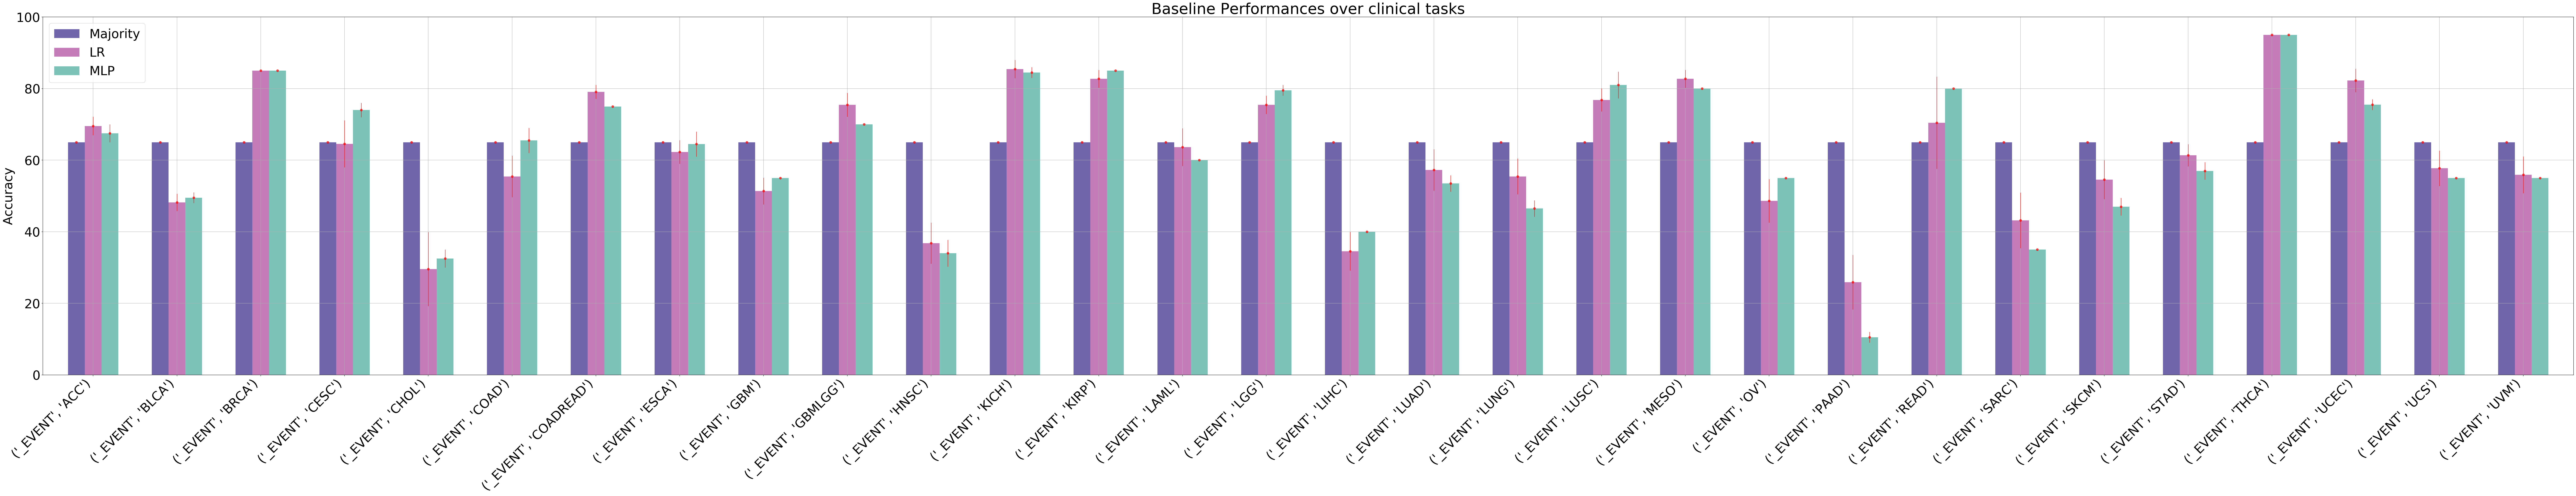

In [94]:
all_visualization(maj_means, lr_means, mlp_means, maj_stds, lr_stds, mlp_stds, tasks_ids) #MLP_dict.keys()) #20samples

In [148]:
print(len(maj_means), len(lr_means), len(mlp_means), len(tasks_ids))

23 23 23 23


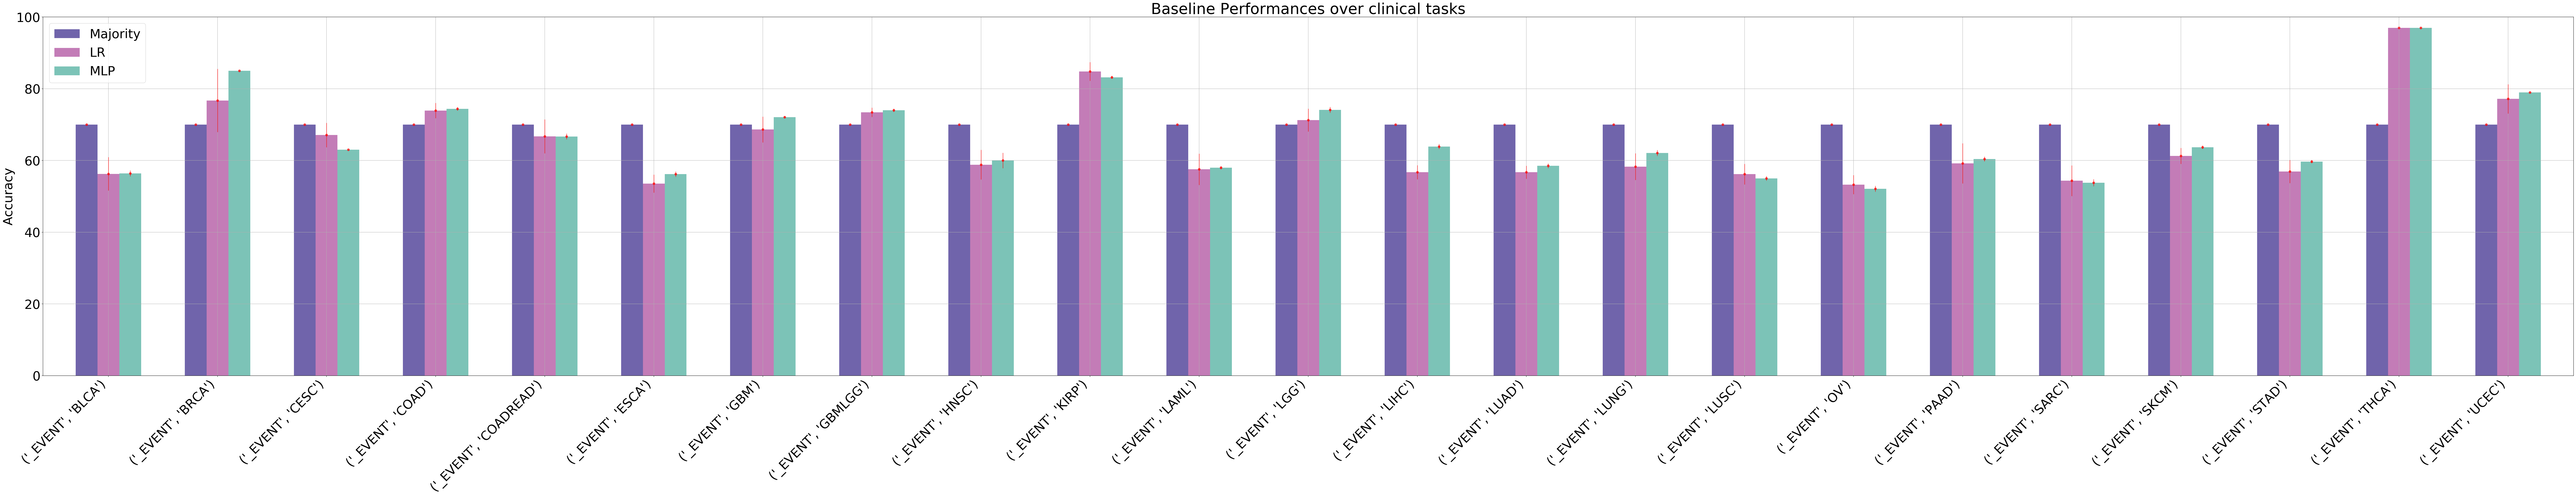

In [149]:
all_visualization(maj_means, lr_means, mlp_means, maj_stds, lr_stds, mlp_stds, tasks_ids) #MLP_dict.keys()) #with normalization- 50samples

In [ ]:
all_visualization(maj_means, knn_means, lr_means, mlp_means, maj_stds, knn_stds, lr_stds, mlp_stds, ) #MLP_dict.keys()) #with normalization- 50samples

In [18]:
mean_mean = [] #over tasks
mean_std = []

mean_mean.append(np.mean(maj_means))
mean_mean.append(np.mean(lr_means))
mean_mean.append(np.mean(knn_means))
mean_mean.append(np.mean(mlp_means))

mean_std.append(np.std(maj_means))
mean_std.append(np.std(lr_means))
mean_std.append(np.std(knn_means))
mean_std.append(np.std(mlp_means))

print(mean_mean)
print(mean_std)

[64.24, 69.96, 67.2, 70.732]
[17.044130954671758, 16.10875538333114, 13.175735273600482, 13.433144680230313]


In [42]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

In [43]:
print(mean_confidence_interval(maj_means))
print(mean_confidence_interval(lr_means))
print(mean_confidence_interval(knn_means))
print(mean_confidence_interval(mlp_means))

(64.24, 57.05945199705609, 71.4205480029439, 7.180548002943905)
(69.96, 63.17351780238548, 76.74648219761451, 6.786482197614511)
(67.2, 61.649174331165455, 72.75082566883455, 5.55082566883455)
(70.732, 65.07272992847749, 76.39127007152251, 5.6592700715225135)


In [32]:
diff_KNN_LR, diff_LR_MLP, diff_KNN_MLP, diff_MLP_PR = [], [], [], []

for i in range(len(knn_means)):
    diff_KNN_LR.append(abs(knn_means[i]- lr_means[i]))
               
for i in range(len(knn_means)):
    diff_LR_MLP.append(abs(lr_means[i]- mlp_means[i]))
               
for i in range(len(knn_means)):
    diff_KNN_MLP.append(abs(knn_means[i]- mlp_means[i]))
    
for i in range(len(knn_means)):
    diff_MLP_PR.append(abs(mlp_means[i]- maj_means[i]))
    
for i in range(len(knn_means)):
    diff_MLP_PR.append(abs(mlp_means[i]- maj_means[i]))

In [33]:
print(diff_KNN_LR, diff_LR_MLP, diff_KNN_MLP, diff_MLP_PR)

[8.700000000000003, 3.700000000000003, 5.799999999999997, 2.700000000000003, 6.600000000000001, 3.1000000000000014, 5.3999999999999915, 0.20000000000000284, 1.7999999999999972, 7.0, 1.7000000000000028, 3.0999999999999943, 3.4000000000000057, 5.099999999999994, 2.5999999999999943, 3.299999999999997, 2.0, 5.599999999999994, 8.599999999999994, 13.5, 12.400000000000006, 17.599999999999994, 19.099999999999994, 0.0, 0.0] [2.4000000000000057, 2.3999999999999986, 0.8000000000000043, 0.8999999999999986, 4.399999999999999, 0.0, 12.999999999999993, 3.0999999999999943, 2.0, 7.299999999999997, 3.5, 6.3999999999999915, 6.1000000000000085, 7.099999999999994, 6.699999999999989, 1.2999999999999972, 3.0999999999999943, 0.6000000000000085, 3.0, 7.400000000000006, 7.6000000000000085, 11.799999999999997, 10.599999999999994, 0.0, 0.0] [6.299999999999997, 6.100000000000001, 6.600000000000001, 3.6000000000000014, 2.200000000000003, 3.1000000000000014, 7.600000000000001, 3.299999999999997, 3.799999999999997, 0

In [37]:
print("The difference of means between KNN and LR")
print("Q2 quantile : ", np.quantile(diff_KNN_LR, .50)) 
print("Q1 quantile : ", np.quantile(diff_KNN_LR, .25)) 
print("Q3 quantile : ", np.quantile(diff_KNN_LR, .75)) 

The difference of means between KNN and LR
Q2 quantile :  3.700000000000003
Q1 quantile :  2.5999999999999943
Q3 quantile :  7.0


In [36]:
print("The difference of means between LR and MLP")
print("Q2 quantile : ", np.quantile(diff_LR_MLP, .50)) 
print("Q1 quantile : ", np.quantile(diff_LR_MLP, .25)) 
print("Q3 quantile : ", np.quantile(diff_LR_MLP, .75)) 

The difference of means between LR and MLP
Q2 quantile :  3.0999999999999943
Q1 quantile :  1.2999999999999972
Q3 quantile :  7.099999999999994


In [38]:
print("The difference of means between KNN and MLP")
print("Q2 quantile : ", np.quantile(diff_KNN_MLP, .50)) 
print("Q1 quantile : ", np.quantile(diff_KNN_MLP, .25)) 
print("Q3 quantile : ", np.quantile(diff_KNN_MLP, .75)) 

The difference of means between KNN and MLP
Q2 quantile :  3.799999999999997
Q1 quantile :  2.200000000000003
Q3 quantile :  6.099999999999994


In [39]:
print("The difference of means between MLP and ProtoNet")
print("Q2 quantile : ", np.quantile(diff_MLP_PR, .50)) 
print("Q1 quantile : ", np.quantile(diff_MLP_PR, .25)) 
print("Q3 quantile : ", np.quantile(diff_MLP_PR, .75)) 

The difference of means between MLP and ProtoNet
Q2 quantile :  6.599999999999994
Q1 quantile :  3.200000000000003
Q3 quantile :  8.700000000000003


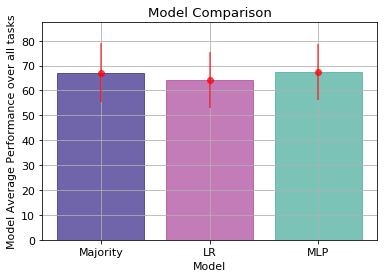

In [40]:
barlist=plt.bar([1,2,3], mean_mean, alpha=0.7)
barlist[0].set_color('#332288')
barlist[1].set_color('#AA4499')
barlist[2].set_color('#44AA99')
plt.xticks([1, 2, 3], ['Majority','LR','MLP'])
plt.title("Model Comparison")
plt.ylabel('Model Average Performance over all tasks')
plt.xlabel('Model')
plt.ylim(0,max(mean_mean)+20)
plt.errorbar([1,2,3], mean_mean, mean_std, linestyle='None', marker='o', color='r', alpha=0.7)
plt.grid()
plt.rcParams.update({'font.size':10})
plt.show()